In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# ============================================================
# ✅ FIX PATH FOR NOTEBOOK INSIDE /notebooks
# ============================================================
import sys, os
from pathlib import Path

# Xác định thư mục cha của notebooks/
project_root = Path(os.getcwd()).parent  # => C:\Users\User\RR_model
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # ⚠️ thêm project_root, KHÔNG thêm src

print("📁 Project root added:", project_root)

# Kiểm tra lại
import importlib.util
print("🔍 src module found:", importlib.util.find_spec("src"))

📁 Project root added: c:\Users\MAFC4709\Python_work\RR_model_1911_Projection
🔍 src module found: ModuleSpec(name='src', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000015611F67730>, origin='c:\\Users\\MAFC4709\\Python_work\\RR_model_1911_Projection\\src\\__init__.py', submodule_search_locations=['c:\\Users\\MAFC4709\\Python_work\\RR_model_1911_Projection\\src'])


In [3]:
# ===========================================================
# 📘 Roll Rate Demo v7 - Sử dụng dữ liệu thật từ Oracle hoặc SQL file
# ===========================================================

from pathlib import Path
import sys
import pandas as pd
import numpy as np

# --- 1️⃣ Setup đường dẫn và import các module ---
root = Path(".").resolve()
sys.path.append(str(root / "src"))

from src.data_loader import load_data
from src.config import CFG, OUT_ROOT
from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob

from src.rollrate.export_excel import export_transition_excel
try:
    from src.rollrate.backtest import (
        compute_actual_matrix,
        rollforward_validation,
        plot_matrix_diff,
        plot_distribution_compare
    )
except Exception as e:
    print("Backtest modules not loaded:", e)

print("✅ Import modules thành công.")
print("Cấu hình CFG:", CFG)


# --- 2️⃣ Load dữ liệu thực tế ---
#sql_path = r"C:/Users/MAFC4709/Python_work/RR_model_1911/sql/uns2.sql"

#df = load_data(sql_path)
df = load_data('C:/Users/MAFC4709/Python_work/RR_model_1911/data/data_CDL_SPL.parquet')
df['DISBURSAL_DATE'] = df['DISBURSAL_DATE'].apply(lambda x: x.replace(day=1))

#print(f"📦 Đã load {len(df):,} dòng dữ liệu từ {sql_path}")

# Kiểm tra các cột quan trọng
required_cols = [CFG["loan"], CFG["mob"], CFG["state"], CFG["ead"], CFG["cutoff"]]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ Thiếu các cột cần thiết trong data: {missing}")

print("✅ Dữ liệu có đủ các cột cần thiết:", required_cols)

# Nếu chưa có PRODUCT_TYPE thì thêm mặc định
if "PRODUCT_TYPE" not in df.columns:
    df["PRODUCT_TYPE"] = "A"
    print("⚠️ Không có PRODUCT_TYPE trong data, gán mặc định = 'A'")

# Convert cutoff về datetime
df[CFG["cutoff"]] = pd.to_datetime(df[CFG["cutoff"]])





✅ Import modules thành công.
Cấu hình CFG: {'loan': 'AGREEMENT_ID', 'mob': 'MOB', 'state': 'STATE_MODEL', 'orig_date': 'DISBURSAL_DATE', 'ead': 'PRINCIPLE_OUTSTANDING', 'disb': 'DISBURSAL_AMOUNT', 'cutoff': 'CUTOFF_DATE'}
📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\RR_model_1911\data\data_CDL_SPL.parquet
✅ Loaded 19,594,814 rows from data_CDL_SPL.parquet
✅ Dữ liệu có đủ các cột cần thiết: ['AGREEMENT_ID', 'MOB', 'STATE_MODEL', 'PRINCIPLE_OUTSTANDING', 'CUTOFF_DATE']


# 0. Import & config chung

In [4]:
import pandas as pd
import numpy as np

from src.config import (
    CFG,
    BUCKETS_CANON,
    BUCKETS_30P,
    BUCKETS_60P,
    BUCKETS_90P,
)

from src.rollrate.transition import compute_transition_by_mob
from src.rollrate.lifecycle import (
    get_actual_all_vintages_amount,
    combine_all_lifecycle_amount,
    lifecycle_to_long_df_amount,
    tag_forecast_rows_amount,
    add_del_metrics,
    aggregate_to_product,
    aggregate_products_to_portfolio,
    export_lifecycle_all_products_one_file,
    extend_actual_info_with_portfolio,
)

from src.rollrate.calibration_kmob import (
    fit_k_raw,
    smooth_k,
    fit_alpha,
    forecast_all_vintages_partial_step,
    plot_k_curves,
    backtest_error_by_mob,
)


# 1. Đọc data loan-level & chuẩn hoá

In [ ]:
df_raw = df[df["PRODUCT_TYPE"] == "CDLPIL"].copy()


In [6]:
# 1.1. Load data loan level


# 1.2. (Tuỳ) Chuẩn hoá tên cột, kiểu dữ liệu nếu cần
df_raw["PRODUCT_TYPE"] = df_raw["PRODUCT_TYPE"].astype(str)
df_raw["RISK_SCORE"]   = df_raw["RISK_SCORE"].astype(str)
df_raw[CFG["orig_date"]] = pd.to_datetime(df_raw[CFG["orig_date"]])


# 2. Build transition matrices theo MOB

In [7]:
matrices_by_mob, parent_fallback = compute_transition_by_mob(df_raw)

# (Tuỳ) validate matrices:
# from src.rollrate.forecast import validate_matrices
# validate_matrices(matrices_by_mob)


⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=500-)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=550-)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=600-)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650+)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=650-)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=CDLPIL, score=OTHERS)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=SPLPIL, score=OTHERS)
⚠️ Có 8 hàng có tổng weight = 0: ['DPD30+', 'DPD60+

# 3. Lifecycle cho các khoản đã giải ngân (actual + forecast “gốc”)

In [8]:
max_mob = 36  # hoac 48, 60 tuy y

states = BUCKETS_CANON
s30_states = BUCKETS_30P

# Actual lifecycle by state (history)
actual_results = get_actual_all_vintages_amount(df_raw)

# Fit window: all vintages (set months to restrict)
FIT_MONTHS = None  # e.g., 6 or 12 to restrict
if FIT_MONTHS is None:
    df_fit = df_raw
else:
    fit_start = df_raw[CFG["orig_date"]].max() - pd.DateOffset(months=FIT_MONTHS)
    df_fit = df_raw[df_raw[CFG["orig_date"]] >= fit_start].copy()

actual_results_fit = get_actual_all_vintages_amount(df_fit)

# DISB_TOTAL map for fit window (cohort-based)
loan_disb_fit = (
    df_fit.groupby(["PRODUCT_TYPE", "RISK_SCORE", CFG["orig_date"], CFG["loan"]])[CFG["disb"]]
    .first()
)
cohort_disb_fit = loan_disb_fit.groupby(level=[0, 1, 2]).sum()
disb_total_by_vintage_fit = cohort_disb_fit.to_dict()


# 4. Fit k theo one-step DEL30 (partial-step overlay)

In [9]:
k_raw_by_mob, weight_by_mob, k_raw_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls",
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print("k_raw_by_mob:", k_raw_by_mob)

if not k_raw_df.empty:
    def _wls_summary(g):
        denom = np.sum(g["weight"] * (g["a"] ** 2))
        numer = np.sum(g["weight"] * g["a"] * g["d"])
        k_wls = k_raw_by_mob.get(int(g.name), np.nan)
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls": k_wls,
        })

    k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()
    k_raw_summary

if k_raw_by_mob:
    mob_min = min(k_raw_by_mob.keys())
    mob_max = max(k_raw_by_mob.keys())
else:
    mob_min, mob_max = 0, 0

k_smooth_by_mob, mobs, _ = smooth_k(
    k_raw_by_mob=k_raw_by_mob,
    weight_by_mob=weight_by_mob,
    mob_min=mob_min,
    mob_max=mob_max,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB = min(max_mob, mob_max) if mob_max else max_mob
alpha, k_final_by_mob, alpha_scores = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_by_mob,
    mob_target=ALPHA_TARGET_MOB,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print("alpha:", alpha)
print("k_final_by_mob:", k_final_by_mob)


k_raw_by_mob: {0: 0.9363622556985733, 1: 1.0, 2: 0.9463233327584109, 3: 0.9569711314982695, 4: 0.9457586480491059, 5: 0.8214003343265134, 6: 0.7812384202830925, 7: 0.6967223588969718, 8: 0.6047272501858434, 9: 0.7650398768963996, 10: 0.6265189322842067, 11: 0.4938441697547664, 12: 0.5572815261678047, 13: 0.5183809733655955, 14: 0.9535585346938814, 15: 1.0, 16: 1.0, 17: 0.08638501171852975, 18: 1.0, 19: 0.9445923622991163, 20: 0.8124212469157338, 21: 0.7914122659071062, 22: 0.9189932541680806, 23: 1.0}
alpha: 1.0
k_final_by_mob: {0: 0.9400614612422277, 1: 0.9906923022587991, 2: 0.9547635604506357, 3: 0.9569839485997378, 4: 0.9363859375370502, 5: 0.8317264346593121, 6: 0.774830766170606, 7: 0.6920529827451122, 8: 0.6327528446869538, 9: 0.7327024905345221, 10: 0.6287974658364888, 11: 0.510920924040252, 12: 0.531566905715762, 13: 0.5751271360701806, 14: 0.9117147829637157, 15: 1.0, 16: 0.8677489662249299, 17: 0.33752997064115253, 18: 0.8453828179381573, 19: 0.9391834162291312, 20: 0.836669

C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_3276\3181303332.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()


In [ ]:
# WLS with regularization (k_prior=0 to bias k downward)
LAMBDA_K = 1e-4
K_PRIOR = 0.0

k_raw_reg_by_mob, weight_reg_by_mob, k_raw_reg_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls_reg",
    lambda_k=LAMBDA_K,
    k_prior=K_PRIOR,
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print('k_raw_reg_by_mob:', k_raw_reg_by_mob)

mobs = sorted(set(k_raw_by_mob) | set(k_raw_reg_by_mob))
df_k_compare = pd.DataFrame({
    'mob': mobs,
    'k_wls': [k_raw_by_mob.get(m, np.nan) for m in mobs],
    'k_wls_reg': [k_raw_reg_by_mob.get(m, np.nan) for m in mobs],
})
df_k_compare['delta'] = df_k_compare['k_wls_reg'] - df_k_compare['k_wls']
display(df_k_compare)


In [ ]:
# Smooth + alpha for regularized k
if k_raw_reg_by_mob:
    mob_min_reg = min(k_raw_reg_by_mob.keys())
    mob_max_reg = max(k_raw_reg_by_mob.keys())
else:
    mob_min_reg, mob_max_reg = 0, 0

k_smooth_reg_by_mob, mobs_reg, _ = smooth_k(
    k_raw_by_mob=k_raw_reg_by_mob,
    weight_by_mob=weight_reg_by_mob,
    mob_min=mob_min_reg,
    mob_max=mob_max_reg,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB_REG = min(max_mob, mob_max_reg) if mob_max_reg else max_mob
alpha_reg, k_final_reg_by_mob, alpha_scores_reg = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_reg_by_mob,
    mob_target=ALPHA_TARGET_MOB_REG,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print('alpha_reg:', alpha_reg)
print('k_final_reg_by_mob:', k_final_reg_by_mob)


In [10]:
# Debug WLS details per MOB (numerator/denominator, fallback, clipping)
MIN_OBS = 5
MIN_DENOM = 1e-10
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data to fit.")
else:
    required = {"mob", "weight", "a", "d"}
    missing = required - set(df.columns)
    if missing:
        print("Missing columns:", missing)
    
    df["w_a2"] = df["weight"] * (df["a"] ** 2)
    df["w_ad"] = df["weight"] * df["a"] * df["d"]
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _agg(g):
        denom = g["w_a2"].sum()
        numer = g["w_ad"].sum()
        k_raw = numer / denom if denom != 0 else np.nan
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls_raw": k_raw,
            "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
            "pct_a_small": (g["a"].abs() < EPS).mean(),
            "pct_k_ratio_gt1": (g["k_ratio"] > 1).mean(),
            "pct_k_ratio_lt0": (g["k_ratio"] < 0).mean(),
            "a_min": g["a"].min(),
            "a_max": g["a"].max(),
            "d_min": g["d"].min(),
            "d_max": g["d"].max(),
        })

    summary = df.groupby("mob").apply(_agg).reset_index()
    summary["wls_used"] = (summary["n_obs"] >= MIN_OBS) & (summary["denom_wls"] >= MIN_DENOM)
    summary["k_from_func"] = summary["mob"].map(k_raw_by_mob)
    summary["is_fallback"] = ~summary["wls_used"]

    display(summary.sort_values("mob"))

    # Inspect a MOB where k is 1 or fallback, if available
    pick = summary[summary["k_from_func"] >= 0.999]
    if pick.empty:
        pick = summary[summary["is_fallback"]]
    if pick.empty:
        mob_to_inspect = summary["mob"].iloc[0]
    else:
        mob_to_inspect = pick["mob"].iloc[0]

    detail = df[df["mob"] == mob_to_inspect].copy()
    detail = detail.sort_values("weight", ascending=False)
    display(detail[["mob", "weight", "a", "d", "k_ratio", "w_a2", "w_ad"]].head(50))


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_3276\1446538653.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,pct_a_small,pct_k_ratio_gt1,pct_k_ratio_lt0,a_min,a_max,d_min,d_max,wls_used,k_from_func,is_fallback
0,0,234.0,234.0,0.000332,0.000311,0.936362,0.936362,0.153846,0.431624,0.000000,0.000000,0.008489,0.000000,0.008491,True,0.936362,False
1,1,227.0,227.0,0.164134,0.168416,1.026087,1.000000,0.008811,0.533040,0.000000,0.000000,0.220770,0.000000,0.232867,True,1.000000,False
2,2,220.0,220.0,0.192775,0.182427,0.946323,0.946323,0.000000,0.386364,0.000000,-0.000432,0.092230,0.000000,0.104431,True,0.946323,False
3,3,213.0,213.0,0.105229,0.100701,0.956971,0.956971,0.000000,0.375587,0.004695,0.000176,0.063157,-0.003895,0.062041,True,0.956971,False
4,4,206.0,206.0,0.266801,0.252330,0.945759,0.945759,0.004854,0.339806,0.000000,0.000000,0.090917,0.000000,0.095562,True,0.945759,False
5,5,199.0,199.0,0.100381,0.082453,0.821400,0.821400,0.000000,0.190955,0.005025,-0.000494,0.066741,-0.007056,0.073203,True,0.821400,False
6,6,192.0,192.0,0.034581,0.027016,0.781238,0.781238,0.000000,0.187500,0.036458,-0.003261,0.033154,-0.017544,0.031987,True,0.781238,False
7,7,185.0,185.0,0.019441,0.013545,0.696722,0.696722,0.005405,0.135135,0.097297,-0.001063,0.027276,-0.020637,0.019232,True,0.696722,False
8,8,178.0,178.0,0.010595,0.006407,0.604727,0.604727,0.000000,0.117978,0.146067,-0.000863,0.025273,-0.004701,0.020950,True,0.604727,False
9,9,171.0,171.0,0.005523,0.004226,0.765040,0.765040,0.000000,0.111111,0.192982,-0.001825,0.018497,-0.031533,0.031694,True,0.765040,False


,mob,weight,a,d,k_ratio,w_a2,w_ad
1,1,1.0,0.029859,0.036785,1.231938,0.000892,0.001098
25,1,1.0,0.091334,0.098585,1.079386,0.008342,0.009004
49,1,1.0,0.075672,0.079205,1.046687,0.005726,0.005994
73,1,1.0,0.051967,0.061989,1.192854,0.002701,0.003221
97,1,1.0,0.050238,0.055843,1.111554,0.002524,0.002805
121,1,1.0,0.059392,0.076427,1.286832,0.003527,0.004539
145,1,1.0,0.059705,0.058547,0.980610,0.003565,0.003496
169,1,1.0,0.034082,0.029067,0.852853,0.001162,0.000991
193,1,1.0,0.026581,0.031082,1.169308,0.000707,0.000826
217,1,1.0,0.035217,0.036163,1.026865,0.001240,0.001274


In [11]:
# Comparison table: Markov vs Actual DEL30 per MOB (weighted)
df = k_raw_df.copy()
req_cols = {"mob", "weight", "y_vm", "y_hat", "y_tar", "a", "d"}
if df.empty:
    print("k_raw_df empty -> no data to compare.")
elif not req_cols.issubset(df.columns):
    print("Missing columns:", req_cols - set(df.columns))
else:
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _wavg(s, w):
        total = w.sum()
        return float(np.average(s, weights=w)) if total > 0 else np.nan

    def _agg(g):
        w = g["weight"]
        y_vm = _wavg(g["y_vm"], w)
        y_hat = _wavg(g["y_hat"], w)
        y_tar = _wavg(g["y_tar"], w)
        denom = float(np.sum(w * (g["a"] ** 2)))
        numer = float(np.sum(w * g["a"] * g["d"]))
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": float(w.sum()),
            "y_vm_wavg": y_vm,
            "y_hat_wavg": y_hat,
            "y_tar_wavg": y_tar,
            "a_wavg": _wavg(g["a"], w),
            "d_wavg": _wavg(g["d"], w),
            "gap_hat_minus_tar": y_hat - y_tar if np.isfinite(y_hat) and np.isfinite(y_tar) else np.nan,
            "k_wls_raw": numer / denom if denom != 0 else np.nan,
            "k_ratio_wavg": _wavg(g["k_ratio"], w),
        })

    compare_by_mob = df.groupby("mob").apply(_agg).reset_index()
    display(compare_by_mob.sort_values("mob"))


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_3276\3471683643.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  compare_by_mob = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,y_vm_wavg,y_hat_wavg,y_tar_wavg,a_wavg,d_wavg,gap_hat_minus_tar,k_wls_raw,k_ratio_wavg
0,0,234.0,234.0,0.000000,0.000767,0.000736,0.000767,0.000736,0.000032,0.936362,NaN
1,1,227.0,227.0,0.000748,0.018263,0.018129,0.017515,0.017381,0.000134,1.026087,NaN
2,2,220.0,220.0,0.018089,0.041083,0.039806,0.022994,0.021717,0.001277,0.946323,0.931696
3,3,213.0,213.0,0.038777,0.056991,0.055883,0.018214,0.017105,0.001108,0.956971,0.922682
4,4,206.0,206.0,0.055605,0.083298,0.081370,0.027693,0.025765,0.001928,0.945759,NaN
5,5,199.0,199.0,0.081240,0.099004,0.095698,0.017765,0.014458,0.003307,0.821400,0.809719
6,6,192.0,192.0,0.096019,0.106655,0.104276,0.010636,0.008257,0.002379,0.781238,0.990113
7,7,185.0,185.0,0.104401,0.112080,0.109565,0.007678,0.005164,0.002514,0.696722,NaN
8,8,178.0,178.0,0.109484,0.115214,0.112964,0.005731,0.003481,0.002250,0.604727,0.532534
9,9,171.0,171.0,0.113441,0.117658,0.115960,0.004217,0.002519,0.001699,0.765040,0.276072


In [12]:
# Detailed WLS breakdown for selected MOBs
MOBS_FOCUS = [10, 11, 12, 13]  # set None for all
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data.")
else:
    focus = df if MOBS_FOCUS is None else df[df["mob"].isin(MOBS_FOCUS)]
    if focus.empty:
        print("No rows for MOBS_FOCUS:", MOBS_FOCUS)
    else:
        def _wavg(x, w):
            total = w.sum()
            return float(np.average(x, weights=w)) if total > 0 else np.nan

        def _mob_diag(g):
            w = g["weight"].values
            a = g["a"].values
            d = g["d"].values
            denom = float(np.sum(w * a * a))
            numer = float(np.sum(w * a * d))
            k_raw = numer / denom if denom != 0 else np.nan
            return pd.Series({
                "n_obs": int(len(g)),
                "w_sum": float(w.sum()),
                "denom_wls": denom,
                "numer_wls": numer,
                "k_wls_raw": k_raw,
                "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
                "a_wavg": _wavg(a, w),
                "d_wavg": _wavg(d, w),
                "pct_a_neg": float(np.mean(a < 0)),
                "pct_d_neg": float(np.mean(d < 0)),
                "pct_sign_mismatch": float(np.mean(np.sign(a) != np.sign(d))),
                "pct_a_small": float(np.mean(np.abs(a) < EPS)),
            })

        mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()
        mob_detail["k_from_func"] = mob_detail["mob"].map(k_raw_by_mob)
        display(mob_detail.sort_values("mob"))

        seg_cols = {"product", "score"}
        if seg_cols.issubset(focus.columns):
            seg = focus.copy()
            seg["segment"] = seg["product"].astype(str) + "|" + seg["score"].astype(str)

            def _seg_diag(g):
                w = g["weight"].values
                a = g["a"].values
                d = g["d"].values
                denom = float(np.sum(w * a * a))
                numer = float(np.sum(w * a * d))
                k_raw = numer / denom if denom != 0 else np.nan
                return pd.Series({
                    "n_obs": int(len(g)),
                    "w_sum": float(w.sum()),
                    "denom_wls": denom,
                    "numer_wls": numer,
                    "k_wls_raw": k_raw,
                    "a_wavg": _wavg(a, w),
                    "d_wavg": _wavg(d, w),
                })

            seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()
            for mob in sorted(seg_detail["mob"].unique()):
                top = seg_detail[seg_detail["mob"] == mob].copy()
                top["abs_numer"] = top["numer_wls"].abs()
                top = top.sort_values("abs_numer", ascending=False).head(10)
                print(f"\nTop segments by |numer| for MOB {mob}")
                display(top[["segment", "n_obs", "w_sum", "numer_wls", "denom_wls", "k_wls_raw", "a_wavg", "d_wavg"]])
        else:
            print("Detail columns missing for segment breakdown (product/score).")


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_3276\2899339469.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,a_wavg,d_wavg,pct_a_neg,pct_d_neg,pct_sign_mismatch,pct_a_small,k_from_func
0,10,164.0,164.0,0.002364,0.001481,0.626519,0.626519,0.002497,0.001138,0.048780,0.420732,0.402439,0.006098,0.626519
1,11,157.0,157.0,0.001262,0.000623,0.493844,0.493844,0.001864,0.000616,0.044586,0.490446,0.515924,0.000000,0.493844
2,12,150.0,150.0,0.000732,0.000408,0.557282,0.557282,0.001353,0.000186,0.026667,0.593333,0.586667,0.020000,0.557282
3,13,143.0,143.0,0.000300,0.000155,0.518381,0.518381,0.000591,-0.000315,0.433566,0.748252,0.377622,0.027972,0.518381



Top segments by |numer| for MOB 10


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_3276\2899339469.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
0,CDLPIL|500-,24.0,24.0,1.053042e-03,0.001510,0.697202,0.007264,0.004469
1,CDLPIL|550-,24.0,24.0,3.026975e-04,0.000531,0.569946,0.004471,0.002475
6,SPLPIL|OTHERS,24.0,24.0,8.753325e-05,0.000155,0.566084,0.001715,0.000905
2,CDLPIL|600-,24.0,24.0,3.684879e-05,0.000137,0.269196,0.002258,0.000593
4,CDLPIL|650-,24.0,24.0,3.791183e-06,0.000026,0.145709,0.000965,0.000054
5,CDLPIL|OTHERS,20.0,20.0,-2.568407e-06,0.000004,-0.731144,0.000294,-0.000512
3,CDLPIL|650+,24.0,24.0,-5.325845e-07,0.000001,-0.518577,0.000142,-0.000298



Top segments by |numer| for MOB 11


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
7,CDLPIL|500-,23.0,23.0,3.998200e-04,7.393994e-04,0.540736,0.005299,0.002652
8,CDLPIL|550-,23.0,23.0,1.095605e-04,3.052887e-04,0.358875,0.003461,0.001205
13,SPLPIL|OTHERS,23.0,23.0,1.041835e-04,1.401258e-04,0.743500,0.001514,0.001131
9,CDLPIL|600-,23.0,23.0,1.275210e-05,6.172007e-05,0.206612,0.001493,0.000138
11,CDLPIL|650-,23.0,23.0,-1.200126e-06,1.396387e-05,-0.085945,0.000668,-0.000318
10,CDLPIL|650+,23.0,23.0,-1.030477e-06,1.123546e-06,-0.917165,0.000188,-0.000209
12,CDLPIL|OTHERS,19.0,19.0,-8.568288e-07,3.731924e-07,-2.295944,0.000119,-0.000480



Top segments by |numer| for MOB 12


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
20,SPLPIL|OTHERS,22.0,22.0,3.063226e-04,2.738704e-04,1.118495,0.001855,0.001493
14,CDLPIL|500-,22.0,22.0,8.574076e-05,2.943479e-04,0.291291,0.003262,0.000786
15,CDLPIL|550-,22.0,22.0,2.248602e-05,1.179841e-04,0.190585,0.002255,0.000400
18,CDLPIL|650-,22.0,22.0,-3.089124e-06,5.159081e-06,-0.598774,0.000436,-0.000484
16,CDLPIL|600-,22.0,22.0,-2.330607e-06,4.016734e-05,-0.058022,0.001219,-0.000286
19,CDLPIL|OTHERS,18.0,18.0,-5.707069e-07,2.614451e-07,-2.182894,0.000089,-0.000464
17,CDLPIL|650+,22.0,22.0,-4.206367e-07,5.833634e-07,-0.721054,0.000125,-0.000263



Top segments by |numer| for MOB 13


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
21,CDLPIL|500-,21.0,21.0,8.912528e-05,2.146168e-04,0.415276,0.002622,0.000018
27,SPLPIL|OTHERS,21.0,21.0,4.230499e-05,3.724211e-05,1.135945,0.000064,0.000213
23,CDLPIL|600-,21.0,21.0,2.277957e-05,2.257552e-05,1.009038,0.000519,-0.000469
25,CDLPIL|650-,21.0,21.0,2.841614e-06,1.984776e-06,1.431705,0.000019,-0.000497
22,CDLPIL|550-,21.0,21.0,-2.252731e-06,2.267049e-05,-0.099368,0.000806,-0.000739
24,CDLPIL|650+,21.0,21.0,3.143921e-07,5.219106e-07,0.602387,0.000014,-0.000251
26,CDLPIL|OTHERS,17.0,17.0,2.100340e-07,1.970465e-08,10.659109,-0.000024,-0.000522


In [13]:
# Step-by-step per vintage using forecast path (MOB 3-6)
VINTAGES_FOCUS = ["2025-08", "2025-09", "2025-10", "2025-11"]
START_MOB = 3
END_MOB = 6
DENOM_MODE = "disb"  # use DISB_TOTAL denominator

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

focus_periods = {pd.Period(v, freq="M") for v in VINTAGES_FOCUS}
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
s30_idx = np.array([states.index(s) for s in s30], dtype=int)

from src.rollrate.calibration_kmob import _get_P_for_segment, forecast_segment_partial_step

rows = []
debug = []
for (prod, score, vintage), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vintage).to_period("M")
    if v_period not in focus_periods:
        continue
    max_actual_mob = max(mob_dict.keys()) if mob_dict else None
    has_start = START_MOB in mob_dict
    debug.append({"vintage_m": str(v_period), "product": prod, "score": score, "max_actual_mob": max_mob, "has_start_mob": has_start})
    if not has_start:
        continue

    key = (prod, score, vintage)
    disb_total = float(disb_map.get(key, 0.0))
    if DENOM_MODE == "disb" and disb_total <= 0:
        continue

    v_start = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    fc = forecast_segment_partial_step(
        matrices_by_mob=matrices_by_mob,
        parent_fallback=parent_fallback,
        product=prod,
        score=score,
        start_mob=START_MOB,
        initial_ead=v_start,
        max_mob=END_MOB,
        k_by_mob=k_final_by_mob,
        states=states,
    )

    for m in range(START_MOB, END_MOB):
        if m not in fc:
            continue
        v_m = fc[m].reindex(states, fill_value=0.0).astype(float)
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        v_hat = v_m.values @ P_df.values
        k_m = float(np.clip(k_final_by_mob.get(m, 1.0), 0.0, 1.0))
        v_adj_next = fc.get(m + 1, v_m + k_m * (pd.Series(v_hat, index=states) - v_m))

        if DENOM_MODE == "disb":
            y_vm = float(np.sum(v_m.values[s30_idx])) / disb_total
            y_hat = float(np.sum(v_hat[s30_idx])) / disb_total
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / disb_total
        else:
            y_vm = float(np.sum(v_m.values[s30_idx])) / float(v_m.values.sum())
            y_hat = float(np.sum(v_hat[s30_idx])) / float(v_hat.sum())
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / float(v_adj_next.values.sum())

        y_tar = np.nan
        if (m + 1) in mob_dict:
            v_m1 = mob_dict[m + 1].reindex(states, fill_value=0.0).astype(float)
            if DENOM_MODE == "disb":
                y_tar = float(np.sum(v_m1.values[s30_idx])) / disb_total
            else:
                y_tar = float(np.sum(v_m1.values[s30_idx])) / float(v_m1.values.sum())

        rows.append({
            "vintage_m": str(v_period),
            "product": prod,
            "score": score,
            "mob_from": m,
            "mob_to": m + 1,
            "k_m": k_m,
            "y_vm": y_vm,
            "y_hat": y_hat,
            "y_adj": y_adj,
            "y_tar": y_tar,
            "step_hat": y_hat - y_vm,
            "step_adj": y_adj - y_vm,
            "has_actual_to": int((m + 1) in mob_dict),
            "base_is_actual": int(m == START_MOB),
        })

df_step = pd.DataFrame(rows)
if df_step.empty:
    print("No rows for selected vintages or MOB range.")
    if debug:
        display(pd.DataFrame(debug).sort_values(["vintage_m", "product", "score"]))
    else:
        available_periods = sorted({pd.to_datetime(k[2]).to_period("M") for k in actual_src.keys()})
        print("Available vintages (last 12):", [str(p) for p in available_periods[-12:]])
else:
    df_step = df_step.sort_values(["vintage_m", "product", "score", "mob_from"])
    display(df_step)

    cols = ["vintage_m", "product", "score", "mob_from", "mob_to", "k_m", "step_hat", "step_adj", "y_vm", "y_adj", "y_tar", "has_actual_to"]
    display(df_step[cols])


,vintage_m,product,score,mob_from,mob_to,k_m,y_vm,y_hat,y_adj,y_tar,step_hat,step_adj,has_actual_to,base_is_actual
0,2025-08,CDLPIL,500-,3,4,0.956984,0.055203,0.092887,0.091266,NaN,0.037684,0.036063,0,1
1,2025-08,CDLPIL,500-,4,5,0.936386,0.091266,0.153225,0.149284,NaN,0.061959,0.058018,0,0
2,2025-08,CDLPIL,500-,5,6,0.831726,0.149284,0.206741,0.197072,NaN,0.057457,0.047789,0,0
3,2025-08,CDLPIL,550-,3,4,0.956984,0.034562,0.055310,0.054417,NaN,0.020747,0.019855,0,1
4,2025-08,CDLPIL,550-,4,5,0.936386,0.054417,0.087312,0.085219,NaN,0.032895,0.030802,0,0
5,2025-08,CDLPIL,550-,5,6,0.831726,0.085219,0.116183,0.110973,NaN,0.030964,0.025753,0,0
6,2025-08,CDLPIL,600-,3,4,0.956984,0.021885,0.034880,0.034321,NaN,0.012995,0.012436,0,1
7,2025-08,CDLPIL,600-,4,5,0.936386,0.034321,0.051396,0.050310,NaN,0.017074,0.015988,0,0
8,2025-08,CDLPIL,600-,5,6,0.831726,0.050310,0.066562,0.063827,NaN,0.016252,0.013517,0,0
9,2025-08,CDLPIL,650+,3,4,0.956984,0.006205,0.008518,0.008419,NaN,0.002313,0.002213,0,1


,vintage_m,product,score,mob_from,mob_to,k_m,step_hat,step_adj,y_vm,y_adj,y_tar,has_actual_to
0,2025-08,CDLPIL,500-,3,4,0.956984,0.037684,0.036063,0.055203,0.091266,NaN,0
1,2025-08,CDLPIL,500-,4,5,0.936386,0.061959,0.058018,0.091266,0.149284,NaN,0
2,2025-08,CDLPIL,500-,5,6,0.831726,0.057457,0.047789,0.149284,0.197072,NaN,0
3,2025-08,CDLPIL,550-,3,4,0.956984,0.020747,0.019855,0.034562,0.054417,NaN,0
4,2025-08,CDLPIL,550-,4,5,0.936386,0.032895,0.030802,0.054417,0.085219,NaN,0
5,2025-08,CDLPIL,550-,5,6,0.831726,0.030964,0.025753,0.085219,0.110973,NaN,0
6,2025-08,CDLPIL,600-,3,4,0.956984,0.012995,0.012436,0.021885,0.034321,NaN,0
7,2025-08,CDLPIL,600-,4,5,0.936386,0.017074,0.015988,0.034321,0.050310,NaN,0
8,2025-08,CDLPIL,600-,5,6,0.831726,0.016252,0.013517,0.050310,0.063827,NaN,0
9,2025-08,CDLPIL,650+,3,4,0.956984,0.002313,0.002213,0.006205,0.008419,NaN,0


In [14]:
# Diagnose DEL30 numerator/denominator at MOB=3 (cohort/product/score)
MOB_CHECK = 3
VINTAGE_CHECK = '2025-08'  # YYYY-MM

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

rows = []
for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if MOB_CHECK not in mob_dict:
        continue
    v = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    key = (prod, score, vint)
    disb = float(disb_map.get(key, 0.0))
    if disb <= 0:
        continue
    num = float(v[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(pd.to_datetime(vint).to_period('M')),
        'mob': MOB_CHECK,
        'del30_num': num,
        'disb_total': disb,
        'del30_pct': num / disb,
    })

df_diag = pd.DataFrame(rows)
if df_diag.empty:
    print('No rows for', VINTAGE_CHECK, 'at MOB', MOB_CHECK)
else:
    display(df_diag.sort_values(['product','score']))
    # Portfolio-level check (weighted by disb_total)
    total_num = df_diag['del30_num'].sum()
    total_disb = df_diag['disb_total'].sum()
    print('Portfolio DEL30:', total_num / total_disb, 'num=', total_num, 'denom=', total_disb)

    # Optional: raw state breakdown for a sample segment
    sample = df_diag.iloc[0] if not df_diag.empty else None
    if sample is not None:
        key = None
        for (prod, score, vint), mob_dict in actual_src.items():
            if pd.to_datetime(vint).to_period('M') == v_target and prod == sample['product'] and score == sample['score']:
                key = (prod, score, vint)
                break
        if key is not None:
            v = actual_src[key][MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
            print('Sample state totals (sum=):', float(v.sum()))
            display(pd.DataFrame({
                'state': states,
                'ead': [float(v[s]) for s in states],
                'is_s30': [s in s30 for s in states],
            }))


,product,score,vintage_m,mob,del30_num,disb_total,del30_pct
0,CDLPIL,500-,2025-08,3,11540.873178,209063.207392,0.055203
1,CDLPIL,550-,2025-08,3,4530.419150,131080.486350,0.034562
2,CDLPIL,600-,2025-08,3,2426.093112,110854.368823,0.021885
3,CDLPIL,650+,2025-08,3,596.002199,96047.457910,0.006205
4,CDLPIL,650-,2025-08,3,1264.711284,83517.959881,0.015143
5,CDLPIL,OTHERS,2025-08,3,886.753675,46807.353100,0.018945
6,SPLPIL,OTHERS,2025-08,3,5119.298694,14804.715594,0.345788


Portfolio DEL30: 0.03808882201658868 num= 26364.151292 denom= 692175.5490499999
Sample state totals (sum=): 169326.265335


,state,ead,is_s30
0,DPD0,146140.582294,False
1,DPD1+,11644.809863,False
2,DPD30+,8007.820206,True
3,DPD60+,3399.055032,True
4,DPD90+,133.997940,True
5,DPD120+,0.000000,True
6,DPD180+,0.000000,True
7,PREPAY,0.000000,False
8,WRITEOFF,0.000000,True
9,SOLDOUT,0.000000,False


In [ ]:
# Markov path detail from actual MOB=2 to MOB=7 for vintage 2025-09 (export to Excel)
VINTAGE_CHECK = '2025-09'  # YYYY-MM
START_MOB = 2
END_MOB = 7
SHOW_P = True  # set True to display P_m matrices

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

from src.rollrate.calibration_kmob import _get_P_for_segment

rows = []
vec_rows = []
p_rows = []

def _record(prod, score, mob, label, vec, disb_total):
    total = float(vec.sum())
    del30_amt = float(vec[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(v_target),
        'mob': mob,
        'label': label,
        'del30_amt': del30_amt,
        'total_ead': total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total if total > 0 else np.nan,
        'disb_total': disb_total,
    })
    for st in states:
        vec_rows.append({
            'product': prod,
            'score': score,
            'vintage_m': str(v_target),
            'mob': mob,
            'label': label,
            'state': st,
            'ead': float(vec.get(st, 0.0)),
        })

for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if START_MOB not in mob_dict:
        continue
    key = (prod, score, vint)
    disb_total = float(disb_map.get(key, 0.0))
    if disb_total <= 0:
        continue

    cur = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    _record(prod, score, START_MOB, 'actual', cur, disb_total)

    for m in range(START_MOB, END_MOB):
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        if SHOW_P:
            print(f'P_m for {prod}-{score} mob={m}')
            display(P_df)
            for i_from, st_from in enumerate(states):
                for j_to, st_to in enumerate(states):
                    p_rows.append({
                        'product': prod,
                        'score': score,
                        'mob': m,
                        'from_state': st_from,
                        'to_state': st_to,
                        'prob': float(P_df.values[i_from, j_to]),
                    })
        v_hat = cur.values @ P_df.values
        cur = pd.Series(v_hat, index=states).astype(float)
        _record(prod, score, m + 1, 'markov', cur, disb_total)

df_step = pd.DataFrame(rows)
df_vec = pd.DataFrame(vec_rows)
df_p = pd.DataFrame(p_rows)

if df_step.empty:
    print('No data for vintage', VINTAGE_CHECK, 'at MOB', START_MOB)
else:
    df_step = df_step.sort_values(['product','score','mob','label'])
    display(df_step)

    # Wide view of state EADs by MOB (actual + Markov)
    df_wide = (
        df_vec.pivot_table(
            index=['product','score','vintage_m','mob','label'],
            columns='state',
            values='ead',
            aggfunc='sum',
            fill_value=0.0,
        )
        .reset_index()
        .sort_values(['product','score','mob','label'])
    )
    display(df_wide)

    # Export to Excel
    from pathlib import Path
    out_dir = Path('outputs')
    out_dir.mkdir(parents=True, exist_ok=True)
    safe_v = VINTAGE_CHECK.replace('-', '')
    out_path = out_dir / f'markov_path_{safe_v}_mob{START_MOB}-{END_MOB}.xlsx'
    try:
        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            df_step.to_excel(writer, sheet_name='step', index=False)
            df_wide.to_excel(writer, sheet_name='states', index=False)
            if not df_p.empty:
                df_p.to_excel(writer, sheet_name='P_matrices', index=False)
        print('Saved Excel:', out_path)
    except Exception as e:
        print('Excel export failed:', e)


In [ ]:
# Compare actual DEL30 for vintages 2024-01..2025-11 at MOB=3 (export to Excel)
VINTAGE_START = '2024-01'
VINTAGE_END = '2025-11'
MOB_CHECK = 3

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage
except NameError:
    disb_map = disb_total_by_vintage_fit if 'disb_total_by_vintage_fit' in globals() else {}

state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
if not s30:
    raise ValueError('No S30 states found in states')

v_start = pd.Period(VINTAGE_START, freq='M')
v_end = pd.Period(VINTAGE_END, freq='M')

rows = []
missing = []
for (prod, score, vint), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vint).to_period('M')
    if v_period < v_start or v_period > v_end:
        continue
    if MOB_CHECK not in mob_dict:
        missing.append((prod, score, str(v_period)))
        continue
    vec = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    del30_amt = float(vec[s30].sum())
    total_ead = float(vec.sum())
    disb_total = float(disb_map.get((prod, score, vint), 0.0))
    rows.append({
        'vintage_m': str(v_period),
        'product': prod,
        'score': score,
        'mob': MOB_CHECK,
        'del30_amt': del30_amt,
        'total_ead': total_ead,
        'disb_total': disb_total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
    })

df_seg = pd.DataFrame(rows)
if df_seg.empty:
    print('No rows for selected vintages and MOB')
else:
    def _agg(g):
        del30_amt = g['del30_amt'].sum()
        disb_total = g['disb_total'].sum()
        total_ead = g['total_ead'].sum()
        return pd.Series({
            'n_seg': int(g.shape[0]),
            'del30_amt': del30_amt,
            'disb_total': disb_total,
            'total_ead': total_ead,
            'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
            'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
        })

    df_vintage = (
        df_seg.groupby('vintage_m').apply(_agg).reset_index().sort_values('vintage_m')
    )
    df_vintage['del30_pct_disb_roll6'] = (
        df_vintage['del30_pct_disb'].rolling(6, min_periods=3).median()
    )
    df_vintage['del30_pct_ead_roll6'] = (
        df_vintage['del30_pct_ead'].rolling(6, min_periods=3).median()
    )
    df_vintage['delta_disb_vs_roll6'] = (
        df_vintage['del30_pct_disb'] - df_vintage['del30_pct_disb_roll6']
    )
    df_vintage['delta_ead_vs_roll6'] = (
        df_vintage['del30_pct_ead'] - df_vintage['del30_pct_ead_roll6']
    )

    df_seg_sorted = df_seg.sort_values(['vintage_m', 'product', 'score'])
    df_seg_sorted['del30_pct_disb_roll6_seg'] = (
        df_seg_sorted.groupby(['product', 'score'])['del30_pct_disb']
        .transform(lambda s: s.rolling(6, min_periods=3).median())
    )
    df_seg_sorted['delta_disb_vs_roll6_seg'] = (
        df_seg_sorted['del30_pct_disb'] - df_seg_sorted['del30_pct_disb_roll6_seg']
    )

    display(df_vintage)
    display(df_vintage.sort_values('delta_disb_vs_roll6', ascending=False).head(10))

    out_path = Path('outputs') / f'vintage_compare_{VINTAGE_START}_{VINTAGE_END}_mob{MOB_CHECK}.xlsx'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
        df_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
        df_seg_sorted.to_excel(writer, index=False, sheet_name='by_segment')

    print('Wrote', out_path)
    if missing:
        df_missing = pd.DataFrame(missing, columns=['product', 'score', 'vintage_m'])
        display(df_missing.head(20))


# 5. Forecast v?i k_final (partial-step) + lifecycle

In [15]:
forecast_results = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_by_mob,
    states=states,
)

lifecycle = combine_all_lifecycle_amount(actual_results, forecast_results)

df_lifecycle = lifecycle_to_long_df_amount(lifecycle)

df_lifecycle = tag_forecast_rows_amount(df_lifecycle, df_raw)

df_lifecycle = add_del_metrics(df_lifecycle, df_raw)

df_lifecycle_final = df_lifecycle


In [ ]:
# Forecast with regularized k and compare to baseline
from pathlib import Path
forecast_results_reg = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_reg_by_mob,
    states=states,
)

lifecycle_reg = combine_all_lifecycle_amount(actual_results, forecast_results_reg)
df_lifecycle_reg = lifecycle_to_long_df_amount(lifecycle_reg)
df_lifecycle_reg = tag_forecast_rows_amount(df_lifecycle_reg, df_raw)
df_lifecycle_reg = add_del_metrics(df_lifecycle_reg, df_raw)

keys = ['PRODUCT_TYPE', 'RISK_SCORE', 'VINTAGE_DATE', 'MOB']
df_old = df_lifecycle_final.copy()
df_new = df_lifecycle_reg.copy()
df_cmp = df_old.merge(df_new, on=keys, how='inner', suffixes=('_wls', '_reg'))
df_cmp = df_cmp[df_cmp['IS_FORECAST_wls'] == 1].copy()

weight_col = 'DISB_TOTAL_wls' if 'DISB_TOTAL_wls' in df_cmp.columns else None

def _wavg(g, col):
    if weight_col and g[weight_col].sum() > 0:
        return (g[col] * g[weight_col]).sum() / g[weight_col].sum()
    return g[col].mean()

by_mob = (
    df_cmp.groupby('MOB')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

by_vintage = (
    df_cmp.groupby('VINTAGE_DATE')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

display(by_mob)
display(by_vintage.sort_values('delta', ascending=False).head(12))

out_path = Path('outputs') / 'compare_forecast_kreg.xlsx'
out_path.parent.mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    by_mob.to_excel(writer, index=False, sheet_name='by_mob')
    by_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
    df_cmp.to_excel(writer, index=False, sheet_name='by_segment')

print('Wrote', out_path)


In [ ]:
# Backtest error comparison (baseline vs regularized k)
from pathlib import Path

err_wls = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_reg = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_reg_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

if err_wls.empty or err_reg.empty:
    print('No backtest rows for comparison')
else:
    err_wls = err_wls.rename(columns={"mae_adj": "mae_adj_wls", "mae_markov": "mae_markov"})
    err_reg = err_reg.rename(columns={"mae_adj": "mae_adj_reg"})
    err_cmp = err_wls.merge(err_reg, on="mob", how="inner")
    err_cmp["delta_mae_adj"] = err_cmp["mae_adj_reg"] - err_cmp["mae_adj_wls"]
    display(err_cmp)

    summary = pd.Series({
        "mae_adj_wls_mean": err_cmp["mae_adj_wls"].mean(),
        "mae_adj_reg_mean": err_cmp["mae_adj_reg"].mean(),
        "delta_mean": err_cmp["delta_mae_adj"].mean(),
    })
    display(summary.to_frame('value'))

    out_err = Path('outputs') / 'compare_backtest_kreg.xlsx'
    out_err.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_err, engine='xlsxwriter') as writer:
        err_cmp.to_excel(writer, index=False, sheet_name='by_mob')
    print('Wrote', out_err)

# Export final lifecycle files (baseline + regularized)
out_lifecycle_base = Path('outputs') / 'lifecycle_calibrated.xlsx'
out_lifecycle_reg = Path('outputs') / 'lifecycle_calibrated_reg.xlsx'
out_lifecycle_base.parent.mkdir(parents=True, exist_ok=True)
df_lifecycle_final.to_excel(out_lifecycle_base, index=False)
df_lifecycle_reg.to_excel(out_lifecycle_reg, index=False)
print('Exported lifecycle baseline -> lifecycle_calibrated.xlsx')
print('Exported lifecycle reg -> lifecycle_calibrated_reg.xlsx')


# 6. Diagnostics (k curves & backtest)

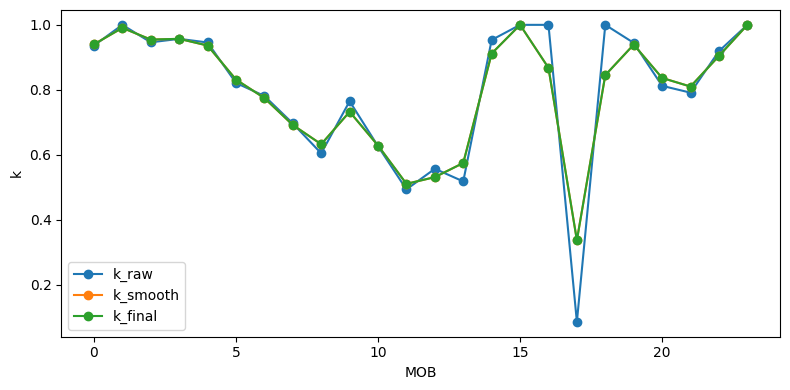

c:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\calibration_kmob.py:831: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mob,mae_adj,mae_markov
0,1,0.000300,0.000299
1,2,0.002038,0.002008
2,3,0.002720,0.002720
3,4,0.002285,0.002288
4,5,0.002711,0.002875
5,6,0.003060,0.004015
6,7,0.002160,0.003034
7,8,0.001871,0.002715
8,9,0.001730,0.002519
9,10,0.001597,0.002151


In [16]:
# Diagnostics
if k_raw_by_mob:
    plot_k_curves(k_raw_by_mob, k_smooth_by_mob, k_final_by_mob)

err_by_mob = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_by_mob


# 7. Seasonality (option – nếu bạn dùng)

In [17]:
# # 7.1. Lấy actual sau calib (hoặc actual trước calib, tuỳ triết lý)
# df_actual_for_season = df_lifecycle_calib[df_lifecycle_calib["IS_FORECAST"] == 0].copy()

# # 7.2. Build seasonality (theo PRODUCT_TYPE × tháng VINTAGE)
# seasonality = build_seasonality(df_actual_for_season, smooth_window=3)

# # 7.3. Áp seasonality cho lifecycle (calib + forecast)
# df_lifecycle_final = apply_seasonality_to_lifecycle(
#     df_lifecycle_calib, seasonality
# )


In [18]:
# df_lifecycle_final da duoc tao o cac cell truoc


# 8. Sale plan: forecast, k-calib, seasonality

## 8.1. Load sale plan và forecast lifecycle theo MOB

In [19]:
# Sale plan section skipped


## 8.2. Áp k & seasonality cho sale plan

In [20]:
# Sale plan section skipped


# 9. Aggregate lên product / portfolio

## 9.1. Từ cohort nhỏ (Product × Score × Vintage × MOB) → lên Product × Vintage × MOB

In [21]:
# Lifecycle history (calibrated + forecast)
df_prod_hist = aggregate_to_product(df_lifecycle_final)

df_prod_hist


c:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:430: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,PRODUCT_TYPE,VINTAGE_DATE,MOB,DEL30_PCT,DEL60_PCT,DEL90_PCT,PRODUCT_DISB
0,CDLPIL,2023-01-01,0,0.000000,0.000000,0.000000,173054.707739
1,CDLPIL,2023-01-01,1,0.000432,0.000000,0.000000,173054.707739
2,CDLPIL,2023-01-01,2,0.007108,0.000403,0.000000,173054.707739
3,CDLPIL,2023-01-01,3,0.015337,0.006828,0.000378,173054.707739
4,CDLPIL,2023-01-01,4,0.020064,0.014047,0.006374,173054.707739
...,...,...,...,...,...,...,...
2585,SPLPIL,2025-11-01,32,0.287067,0.287067,0.287067,5810.394913
2586,SPLPIL,2025-11-01,33,0.287067,0.287067,0.287067,5810.394913
2587,SPLPIL,2025-11-01,34,0.287067,0.287067,0.287067,5810.394913
2588,SPLPIL,2025-11-01,35,0.287067,0.287067,0.287067,5810.394913


## 9.2. Gộp nhiều product thành portfolio

In [22]:
portfolio_filter = ["CDLPIL", "SALPIL", "SPLPIL", "TOPUP", "TWLPIL", "XSELL"]

df_portfolio_hist = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)


c:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [23]:
df_export = pd.concat([
    df_prod_hist,
    df_portfolio_hist,
], ignore_index=True)


In [ ]:
# Lifecycle history (regularized k)
df_prod_hist_reg = aggregate_to_product(df_lifecycle_reg)

df_portfolio_hist_reg = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist_reg,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)

df_export_reg = pd.concat(
    [df_prod_hist_reg, df_portfolio_hist_reg],
    ignore_index=True,
)


In [25]:
actual_info_prod = (
    df_raw.groupby(["PRODUCT_TYPE", CFG["orig_date"]])["MOB"]
    .max()
    .to_dict()
)

actual_info_all = extend_actual_info_with_portfolio(
    actual_info_prod,
    portfolio_name="TOTAL_PIL",
)

try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)
try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export_reg,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated_reg.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)


✔ Export lifecycle multi-product thành công → lifecycle_calibrated.xlsx


# 10. Export Excel 